In [3]:
# Install necessary packages
!pip install gymnasium torch numpy matplotlib ambiance aerodynamics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
%cd gdrive/MyDrive/new_RLproject2

/content/gdrive/MyDrive/new_RLproject2


In [6]:
!ls

 6DOF.py		        README.md		       two_stage_rocket.py
 aerodynamics.py	        rocket.py		       two_stage_rocket_w_aerodynamics.py
 coordinate_of_the_system.jpg  'single_stage_rocket copy.py'   Untitled0.ipynb
 kerbin_aerodynamics.txt        single_stage_rocket.py	       utils.py
 policy.py		        test_rocket.py
 __pycache__		        test_train.py


In [13]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from ambiance import Atmosphere
import gymnasium as gym
from gymnasium import spaces
from rocket import Rocket  # Import Rocket class from rocket.py

In [14]:
from torch.distributions import Normal

In [15]:
Path = '/content/gdrive/MyDrive/new_RLproject2/traindata/ppo_train_data.'

Episode 0, Reward: 0


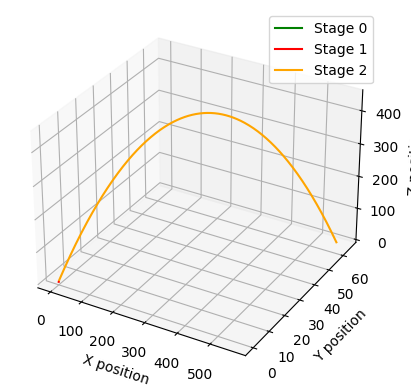

Model saved at /content/gdrive/MyDrive/new_RLproject2/traindata/ppo_rocket_model.pth
Episode 100, Reward: 0


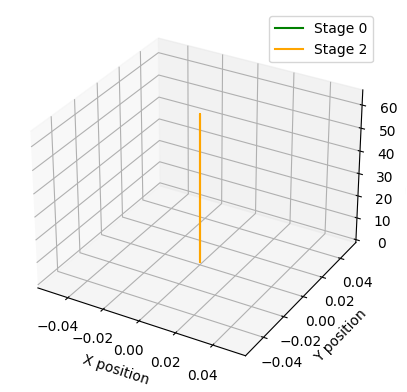

Model saved at /content/gdrive/MyDrive/new_RLproject2/traindata/ppo_rocket_model.pth
Episode 200, Reward: 0


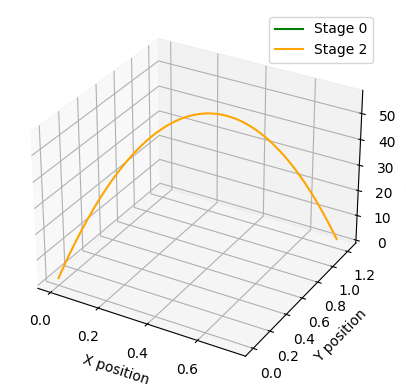

Model saved at /content/gdrive/MyDrive/new_RLproject2/traindata/ppo_rocket_model.pth
Episode 300, Reward: 0


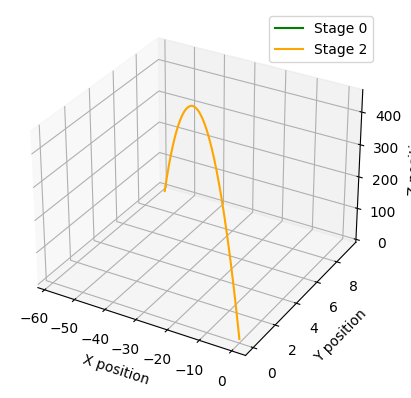

Model saved at /content/gdrive/MyDrive/new_RLproject2/traindata/ppo_rocket_model.pth
Episode 400, Reward: 0


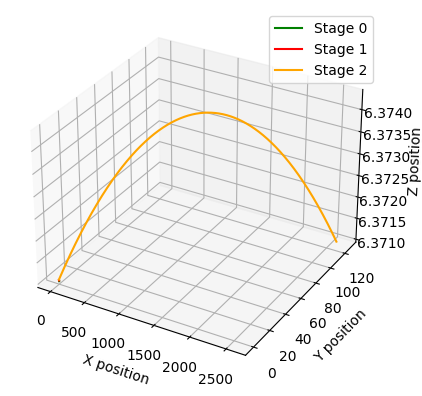

Model saved at /content/gdrive/MyDrive/new_RLproject2/traindata/ppo_rocket_model.pth
Episode 500, Reward: 0


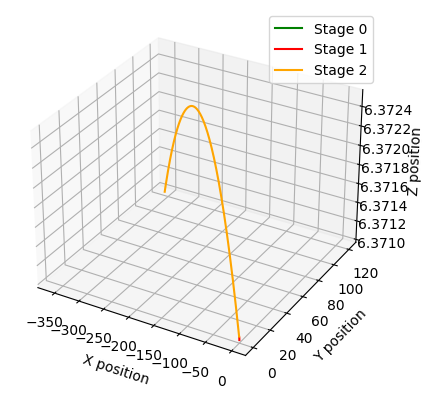

Model saved at /content/gdrive/MyDrive/new_RLproject2/traindata/ppo_rocket_model.pth
Episode 600, Reward: 0


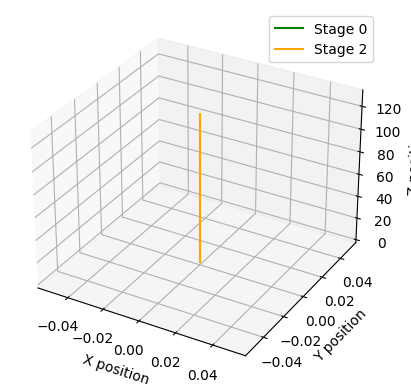

Model saved at /content/gdrive/MyDrive/new_RLproject2/traindata/ppo_rocket_model.pth
Episode 700, Reward: 0


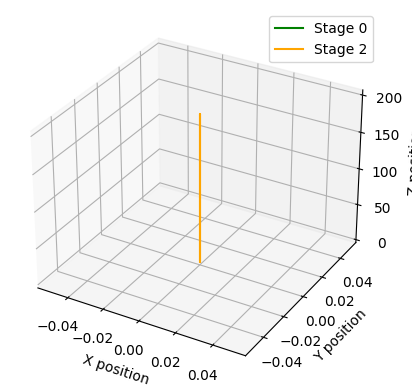

Model saved at /content/gdrive/MyDrive/new_RLproject2/traindata/ppo_rocket_model.pth
Episode 800, Reward: 0


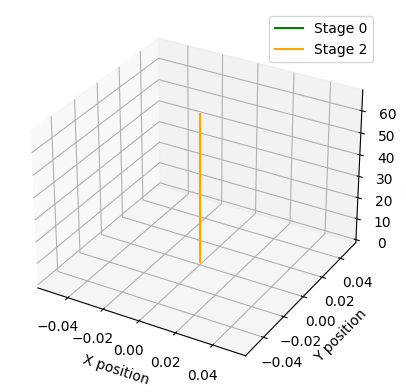

Model saved at /content/gdrive/MyDrive/new_RLproject2/traindata/ppo_rocket_model.pth
Episode 900, Reward: 0


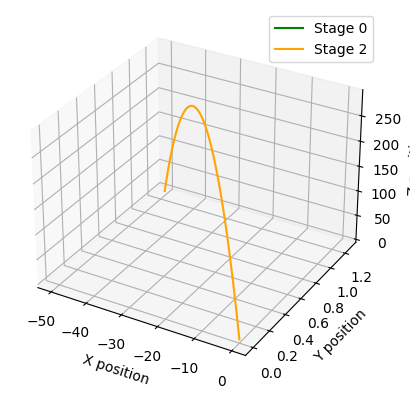

Model saved at /content/gdrive/MyDrive/new_RLproject2/traindata/ppo_rocket_model.pth
Final model saved at /content/gdrive/MyDrive/new_RLproject2/traindata/ppo_rocket_model.pth


In [ ]:
class PPORocketAgent(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PPORocketAgent, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        return self.actor(state), self.critic(state)

    def get_action(self, state):
        action_mean, _ = self.forward(state)
        action_log_std = self.log_std.expand_as(action_mean)
        action_std = torch.exp(action_log_std)
        normal = Normal(action_mean, action_std)
        action = normal.sample()
        action_log_prob = normal.log_prob(action).sum(dim=-1)
        return action, action_log_prob

def scale_action(action, low, high):
    scaled_action = low + (0.5 * (action + 1.0) * (high - low))
    return scaled_action

def normalize_state(state):
    return (state - state.mean()) / (state.std() + 1e-8)

def train_ppo_agent(env, agent, num_episodes=1000, learning_rate=1e-4, gamma=0.99, clip_epsilon=0.2, update_timestep=2000, k_epochs=4, save_path='/content/gdrive/MyDrive/new_RLproject2/traindata/'):
    optimizer = optim.Adam(agent.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()
    timestep = 0
    episode_rewards = []

    action_low = np.array([-3] * 10 + [0] * 5 + [-3] * 6 + [0] * 3 + [0])
    action_high = np.array([3] * 10 + [env.max_thrust[0]] * 5 + [3] * 6 + [env.max_thrust[1]] * 3 + [3])

    # Load the model if it exists
    model_path = os.path.join(save_path, 'ppo_rocket_model.pth')
    if os.path.exists(model_path):
        agent.load_state_dict(torch.load(model_path))
        print("Model loaded successfully!")

    for episode in range(num_episodes):
        state = env.reset()
        state = torch.FloatTensor(state).unsqueeze(0)
        episode_reward = 0

        for t in range(env.max_step):
            timestep += 1
            state = normalize_state(state)  # Normalize the state
            action, action_log_prob = agent.get_action(state)
            scaled_action = scale_action(action.detach().numpy()[0], action_low, action_high)
            next_state, reward, done, _ = env.step(scaled_action)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)

            episode_reward += reward
            advantage = reward + gamma * agent(next_state)[1].item() - agent(state)[1].item()
            advantage = torch.tensor(advantage).view(-1, 1).detach()  # Convert to tensor and detach

            # Collect experience
            if timestep % update_timestep == 0:
                # PPO Update
                for _ in range(k_epochs):
                    state = normalize_state(state)  # Normalize the state
                    action_mean, state_value = agent(state)
                    action_log_std = agent.log_std.expand_as(action_mean)
                    action_std = torch.exp(action_log_std)
                    normal = Normal(action_mean, action_std)
                    log_prob = normal.log_prob(action).sum(dim=-1)
                    ratio = torch.exp(log_prob - action_log_prob.detach())
                    surr1 = ratio * advantage
                    surr2 = torch.clamp(ratio, 1-clip_epsilon, 1+clip_epsilon) * advantage
                    actor_loss = -torch.min(surr1, surr2).mean()
                    critic_loss = mse_loss(state_value, torch.tensor([reward + gamma * agent(next_state)[1].item()]).view(-1, 1).float().detach())
                    loss = 0.5 * critic_loss + actor_loss

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            state = next_state

            if done:
                break

        episode_rewards.append(episode_reward)

        if episode % 100 == 0:
            print(f"Episode {episode}, Reward: {episode_reward}")
            env.show_path_from_state_buffer()
            # Save the model
            torch.save(agent.state_dict(), model_path)
            print(f"Model saved at {model_path}")

    # Final save
    torch.save(agent.state_dict(), model_path)
    print(f"Final model saved at {model_path}")

    return episode_rewards

# Create the environment and agent
env = Rocket()
state_dim = env.state_dims
action_dim = env.action_dims
agent = PPORocketAgent(state_dim, action_dim)

# Train the agent
episode_rewards = train_ppo_agent(env, agent, num_episodes=1000)